In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import torch
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import geomloss
import sys
import argparse

from model.stDiff_model import DiT_stDiff
from utils import save_log_file, save_model, SinkhornLoss


/home/hanyuji/miniconda3/envs/DYffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
python train_scDYff_DiT.py --dataset DR --ntps 11 --batch_size 1024
python train_scDYff_DiT.py --dataset EB --ntps 5 --batch_size 2048
python train_scDYff_DiT.py --dataset MB --ntps 13 --batch_size 1024
python train_scDYff_DiT.py --dataset MP --ntps 4 --batch_size 2048
python train_scDYff_DiT.py --dataset ZB --ntps 12 --batch_size 512

'''


# # >>> 模型输入参数 >>>
# parser = argparse.ArgumentParser(description='Process some parameters.')

# # 添加参数
# parser.add_argument('--dataset', type=str, required=True)
# parser.add_argument('--ntps', type=int, required=True)
# parser.add_argument('--batch_size', type=int, required=True)

# args = parser.parse_args()  # 解析参数

# dataset_name = args.dataset
# dataset_ntps = args.ntps
# batch_size = args.batch_size

# print(
#     f'-----dataset_name: {dataset_name}, dataset_ntps: {dataset_ntps}, batch_size: {batch_size}-----'
# )
# # <<< 模型输入参数 <<<

para_dict = {
    'DR':(11,1024),
    'EB':(5,2048),
    'MB':(13,1024),
    'MP':(4,2048),
    'ZB':(12,512),
}


dataset_name = 'DR'
dataset_ntps = para_dict[dataset_name][0]
batch_size = para_dict[dataset_name][1]


In [4]:
gene_num = 50
depth = 6
hidden_size = 512
head = 16


model = DiT_stDiff(
    input_size=gene_num * 2,
    output_size=gene_num,
    hidden_size=hidden_size,
    depth=depth,
    num_heads=head,
    classes=6,
    dit_type='dit',
    mlp_ratio=4.0,
)

# label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
label_list = list(range(dataset_ntps))



In [5]:
dataset_path = (
    f'/home/hanyuji/Results/VAE_result/data_latent/{dataset_name}_latent_50.pkl'
)

with open(dataset_path, 'rb') as f:
    data_list = pickle.load(f)


In [6]:
def CombinationDataloader(data_list, label_list):
    combinations = []  # 存储所有可能的三点组合
    combinations_label = []

    # 生成所有可能的三点组合
    for i in range(len(data_list)):
        for j in range(i + 1, len(data_list)):
            for k in range(j + 1, len(data_list)):
                combinations.append((data_list[i], data_list[j], data_list[k]))
                combinations_label.append((label_list[i], label_list[j], label_list[k]))

    return (combinations, combinations_label)


combinations, combinations_label = CombinationDataloader(data_list, label_list)

In [7]:
lr = 1e-4
device = torch.device('cuda:0')
num_epoch = 1600
criterion = SinkhornLoss
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)


loss_log = []

input_size = 50


t_epoch = tqdm(range(num_epoch), ncols=100)

model.train()
for epoch in t_epoch:
    epoch_loss = 0.0
    for i, (c, l) in enumerate(zip(combinations, combinations_label)):

        c0, c1, c2 = c[0], c[1], c[2]

        cell_idx_0 = np.random.choice(
            np.arange(c0.shape[0]), size=batch_size, replace=(c0.shape[0] < batch_size)
        )
        cell_idx_1 = np.random.choice(
            np.arange(c1.shape[0]), size=batch_size, replace=(c1.shape[0] < batch_size)
        )
        cell_idx_2 = np.random.choice(
            np.arange(c2.shape[0]), size=batch_size, replace=(c2.shape[0] < batch_size)
        )
        c0 = c0[cell_idx_0, :]
        c1 = c1[cell_idx_1, :]
        c2 = c2[cell_idx_2, :]

        x13 = np.concatenate([c0, c2], axis=1)  # batchsize, 100
        x13, x2 = (
            torch.tensor(x13).type(torch.float32).to(device),
            torch.tensor(c1).type(torch.float32).to(device),
        )

        t = (l[1] - l[0]) / (l[2] - l[0])
        t = torch.tensor(np.full(c0.shape[0], t)).type(torch.float32).to(device)

        x2_pred = model(x13, t=t)
        loss = criterion(x2, x2_pred)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # type: ignore
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / (i + 1)  # type: ignore

    loss_log.append(epoch_loss)
    save_log_file(loss_log, dataset_name)
    if epoch % 200 == 0:
        save_model(model, dataset_name, epoch)

    t_epoch.set_postfix_str(f'loss:{epoch_loss:.5f}')  # type: ignore




  0%|                                                                      | 0/1600 [00:07<?, ?it/s]


KeyboardInterrupt: 

List loaded successfully.


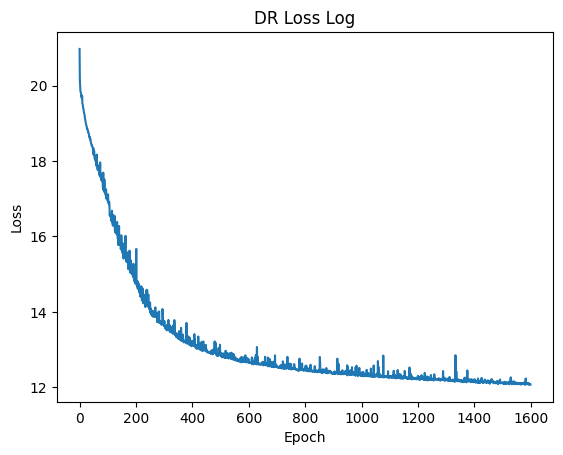

In [12]:
# 损失曲线
file_path = f'/home/hanyuji/Results/scDYff/loss_log/loss_log_{dataset_name}.pt'

with open(file_path, 'rb') as f:
    loaded_list = pickle.load(f)
print("List loaded successfully.")


plt.figure()
plt.plot(loaded_list)
plt.title(f'{dataset_name} Loss Log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Saving the plot to a file
# file_path = f'/home/hanyuji/Results/scDYff/loss_log/plot_loss_log_{dataset_name}.png' 
# plt.savefig(file_path)
plt.show()
plt.close()
